## Introduction

Another option to directly analyze the constraint force time traces, is to calculate $\Delta G$ on-the-fly 
 starting from the friction estimate ${\it{\Gamma}}$ 
 which is calculated from the force $f_c(t)$ auto correlation via:

$$
\begin{align}
\Gamma &= \beta \int_{0}^{t} \text{d}\tau \left<\delta f_c(t)\delta f_c(t-\tau)\right>_\text{N},\\
\Delta G(x) &= - v_c\int_{x_0}^{x} \text{d}x' \Gamma(x') + \int_{x_0}^{x} \text{d}x' \left<f_c(x')\right>_\text{N}
\end{align}
$$

This approach is computionally more demanding, since the full resolution of the force time traces is needed to determine friction and free energy estimates.
Therefore, we advise the use of the WorkEstimator class, which is computationally less demanding, since it does not require the full resolution of the force time traces.

## Workflow:

### 0. load packages and define variables

In [1]:
import numpy as np
from dcTMD.dcTMD import ForceEstimator
from dcTMD.storing import ForceSet, load
import dcTMD

In [2]:
# define variables
velocity = 0.001
res = 1
verbose = True
temperature = 300

### I. create forceset
To calculate free energy and friction estimates a forceset containing all the force time traces is needed.

1. an array containing the filenames is generated.
    This can be done via the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.

In [3]:
pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)

filenames


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)


['../../tests/testdata/t_middle_16_pullf.xvg',
 '../../tests/testdata/t_middle_26_pullf.xvg',
 '../../tests/testdata/t_middle_29_pullf.xvg',
 '../../tests/testdata/t_middle_32_pullf.xvg',
 '../../tests/testdata/t_middle_19_pullf.xvg',
 '../../tests/testdata/t_middle_03_pullf.xvg',
 '../../tests/testdata/t_middle_04_pullf.xvg',
 '../../tests/testdata/t_middle_05_pullf.xvg',
 '../../tests/testdata/t_middle_25_pullf.xvg',
 '../../tests/testdata/t_middle_31_pullf.xvg',
 '../../tests/testdata/t_middle_21_pullf.xvg',
 '../../tests/testdata/t_middle_17_pullf.xvg',
 '../../tests/testdata/t_middle_24_pullf.xvg',
 '../../tests/testdata/t_middle_09_pullf.xvg',
 '../../tests/testdata/t_middle_28_pullf.xvg',
 '../../tests/testdata/t_middle_30_pullf.xvg',
 '../../tests/testdata/t_middle_34_pullf.xvg',
 '../../tests/testdata/t_middle_01_pullf.xvg']

2. the forceset is created by creating a ForceSet instance which is fitted with the filenames. 

In [4]:
# create ForceSet instance
forceset = ForceSet(velocity=velocity,
                  resolution=res,
                  verbose=verbose,
                  )
forceset


ForceSet(velocity=0.001, verbose=True)

In [5]:
# fit/fill workset
forceset.fit(filenames)
# save workset
#dcTMD.storing.save('my_forceset', forceset)



Using ../../tests/testdata/t_middle_16_pullf.xvg to initialize arrays.
length of pullf file is 20001
reduced length is 20001


Loading force files: 100%|██████████| 18/18 [00:00<00:00, 124.29it/s]

Reading file ../../tests/testdata/t_middle_16_pullf.xvg
Reading file ../../tests/testdata/t_middle_26_pullf.xvg
Reading file ../../tests/testdata/t_middle_29_pullf.xvg
Reading file ../../tests/testdata/t_middle_32_pullf.xvg
Reading file ../../tests/testdata/t_middle_19_pullf.xvg
Reading file ../../tests/testdata/t_middle_03_pullf.xvg
Reading file ../../tests/testdata/t_middle_04_pullf.xvg
Reading file ../../tests/testdata/t_middle_05_pullf.xvg
Reading file ../../tests/testdata/t_middle_25_pullf.xvg
Reading file ../../tests/testdata/t_middle_31_pullf.xvg
Reading file ../../tests/testdata/t_middle_21_pullf.xvg
Reading file ../../tests/testdata/t_middle_17_pullf.xvg
Reading file ../../tests/testdata/t_middle_24_pullf.xvg
Reading file ../../tests/testdata/t_middle_09_pullf.xvg
Reading file ../../tests/testdata/t_middle_28_pullf.xvg
Reading file ../../tests/testdata/t_middle_30_pullf.xvg
Reading file ../../tests/testdata/t_middle_34_pullf.xvg
Reading file ../../tests/testdata/t_middle_01_pu

ForceSet(velocity=0.001, verbose=True)

### II. check normality of work distribution

One of the main conditions which need to be fulfilled for dcTMD is a normally distributed work.

This can be checked via different methods. e.g. plotting the work time traces, normality checks at different x positions, Kolmogorov-Smirnov Test, Shapiro-Wilk Test, Anderson-Darling Test

CAUTION: if the work distribution is not normal you results are compromised. And a path separation is necessary. For the theory on path separation see...

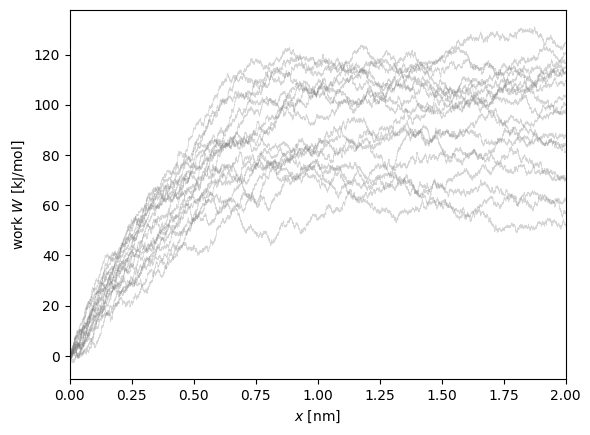

In [6]:
# plot workset
import matplotlib.pyplot as plt
from dcTMD.utils import plotting

fig, ax = plt.subplots()
plotting.plot_worklines(forceset, ax)
plt.show()

In [7]:
from scipy.stats import probplot

def plot_worknormalitychecks(
    workset,
    index,
    x=None,
    worklinecolor='#777',
    colors=None,
    figsize=(6, 2),
    axs=None,
    res=10,
):
    """Plots the work values of trajectories individually.

    This function generates a plot with three subplots:
    1. Line plots of the work values for all trajectories.
    2. Work value histograms for the indices given `index`.
    3. As well as normality plot (Q-Q plot) for the work values the indices given `index`..

    Args:
        workset: workset object
        index (list of int): Indices of the positions. These indices
            are used to extract specific columns from `workset.work_` for
            histogram and normality plots.
        x (array-like, optional): The x-axis positions for the work values. If
            not provided, `workset.position_` is used.
        worklinecolor (str, optional): Color of the work line plot. Default is
            '#777'.
        colors (list of str, optional):
            Colors for the histogram and normality
            plots. If not provided, the `Dark2` colormap is used.
        figsize (tuple, optional):
            Size of the figure. Default is (6, 2).
        axs (list of matplotlib.axes.Axes, optional):
            Axes for the subplots. If
            not provided, new axes are created.
        res (int, optional): Resolution for the work line plot. Default is 10.

    Returns:
        list of matplotlib.axes.Axes: The axes containing the subplots.

    Example:
        >>> plot_worknormalitychecks(
        ...     workset=my_workset,
        ...     index=[0, 5, 10],
        ... )
        >>> plt.show()

    """
    if axs is None:
        print('No axs given. Create figure.')
        fig, axs = plt.subplots(
            ncols=3,
            nrows=1,
            figsize=figsize,
        )
    if x is None:
        x = workset.position_
    plotting.plot_worklines(workset, axs[0], x=x, res=res, color=worklinecolor)

    if not colors:
        cmap = plt.get_cmap('Dark2')
        colors = cmap.colors

    for j, idx in enumerate(index):
        work = workset.work_[:, idx].ravel()
        axs[1].set_title(r'Histogram at $x$')
        plotting.plot_histo_normaldist(work, axs[1], colors[j])
        axs[0].axvline(x[idx],
                       color=colors[j],
                       zorder=3,
                       label=rf'$x={x[idx]:.2f}$',
                       )

        probplot(work, plot=axs[2], fit=True)
        axs[2].get_lines()[j * 2].set_color(colors[j])  # noqa: WPS221
        axs[2].set_title('Normality plot')

    axs[0].legend()
    return axs

No axs given. Create figure.
shapiro wilkins results at x=0.5 is ShapiroResult(statistic=0.9809889406089319, pvalue=0.9596362343433563)
anderson darling results at x=0.5 is AndersonResult(statistic=0.1889729620402001, critical_values=array([0.503, 0.573, 0.687, 0.802, 0.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=67.2816159481796, scale=12.135336573012399)
 success: True
 message: '`anderson` successfully fit the distribution to the data.').
Kolmogorov-Smirnov results at x=0.5 is KstestResult(statistic=0.12229979875552949, pvalue=0.9209557348362535, statistic_location=-1.0132181812586847, statistic_sign=1)
shapiro wilkins results at x=1.5 is ShapiroResult(statistic=0.9350144421408513, pvalue=0.237681372960928)
anderson darling results at x=1.5 is AndersonResult(statistic=0.38109849215264546, critical_values=array([0.503, 0.573, 0.687, 0.802, 0.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: Fi

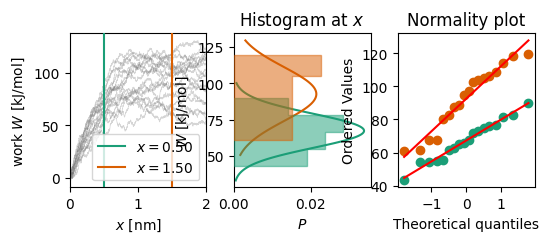

In [8]:
# check if work distribution follows a normal distribution
from scipy.stats import kstest, shapiro, anderson
from dcTMD.utils import plotting

index = [5000, 15000]
x = forceset.position_

axs = plot_worknormalitychecks(forceset, index)

for i, p in enumerate(index):
    # Shapiro-Wilk Test
    shapiro_test = shapiro(forceset.work_[:,p])
    print(f'shapiro wilkins results at x={x[p]} is {shapiro_test}')
    # Anderson-Darling Test
    # If the test statsitics is larger than the critical value of a given
    # significance_level in percent, the null hypothesis that the work
    # is normally distributed has to be rejected.
    anderson_test = anderson(forceset.work_[:,p], 'norm')
    print(f'anderson darling results at x={x[p]} is {anderson_test}.')
    # Kolmogorov-Smirnov Test (requires centering and scaling of input data)
    kstest_test = kstest(
        (forceset.work_[:,p]-np.mean(forceset.work_[:,p]))/np.std(forceset.work_[:,p]),
        'norm'
    )
    print(f'Kolmogorov-Smirnov results at x={x[p]} is {kstest_test}')

### III. derive estimates from forceset

1. create ForceEstimator instance
2. fit ForceEstimator instance with previously created forceset

In [9]:
## load force
# force = load('my_force_set')
# Instantiate a ForceEstimator instance and fit it with the ForceSet
# instance
forceestimator = ForceEstimator(temperature)
forceestimator.fit(forceset)
vars(forceestimator)

{'temperature': 300,
 'verbose': False,
 'force_set': ForceSet(velocity=0.001, verbose=True),
 'names_': array(['t_middle_16_pullf.xvg', 't_middle_26_pullf.xvg',
        't_middle_29_pullf.xvg', 't_middle_32_pullf.xvg',
        't_middle_19_pullf.xvg', 't_middle_03_pullf.xvg',
        't_middle_04_pullf.xvg', 't_middle_05_pullf.xvg',
        't_middle_25_pullf.xvg', 't_middle_31_pullf.xvg',
        't_middle_21_pullf.xvg', 't_middle_17_pullf.xvg',
        't_middle_24_pullf.xvg', 't_middle_09_pullf.xvg',
        't_middle_28_pullf.xvg', 't_middle_30_pullf.xvg',
        't_middle_34_pullf.xvg', 't_middle_01_pullf.xvg'], dtype='<U32'),
 'delta_force_array': array([[ -522.42118333, -2378.93973333,   633.71216667, ...,
          1499.32438889,    69.02975556,  2283.61911111],
        [ 2488.41481667, -2751.03973333,  -922.63583333, ...,
          1105.01438889,  1294.69275556,  1361.89911111],
        [-1194.77918333,   -36.94853333,  1910.80916667, ...,
           974.07438889, -1465.1572

#### Visualize results
In the package a couple of simple plot functions to get an overview of the results are implemented. e.g. plot_dcTMD_results()

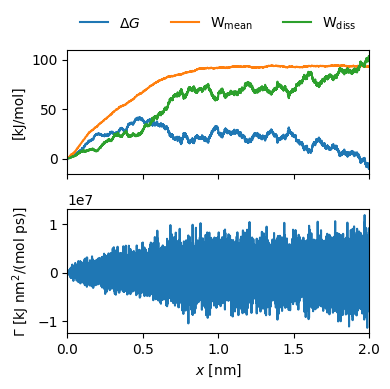

In [10]:
# plot dcTMD results
from dcTMD.utils import plotting

fig, axs = plotting.plot_dcTMD_results(forceestimator)

plt.show()

#### Smooth friction estimate
Finally, the friction estimate needs to be smoothed.
This can be done via 
dcTMD.utils.smoothing.gaussfilter_friction() or 
dcTMD.WorkEstimator.smooth_friction(sigma, mode)
sigma is the standard deviation of gaussian kernel in nm
the mode parameter determines how the input array is extended beyond its boundaries.

*Caution:* this can lead to long computations using large datasets and a big smoothing window.

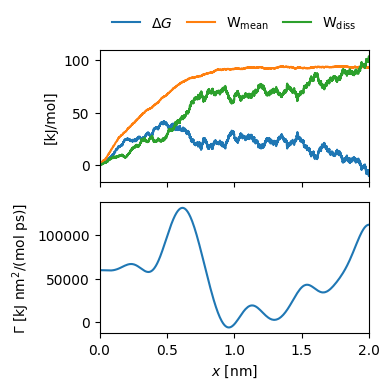

In [11]:
# smooth friction and plot results
forceestimator.smooth_friction(sigma=0.1)

# if the friction is smoothed that value is automatically plotted
fig, axs = plotting.plot_dcTMD_results(forceestimator)
plt.show()

# but one can also specify the friction
#fig, axs = plotting.plot_dcTMD_results(
#    forceestimator,
#    friction=forceestimator.friction_
#)



Using different smoothing windows and modes changes the results significantly. Because of the different boundary handling in the modes. mode='nearest' leads to an overestimation at the right hand boarder (end of the simulation), while mode='reflect' leads to a wash out of the boarder on the left hand side.

Here, are some examples:

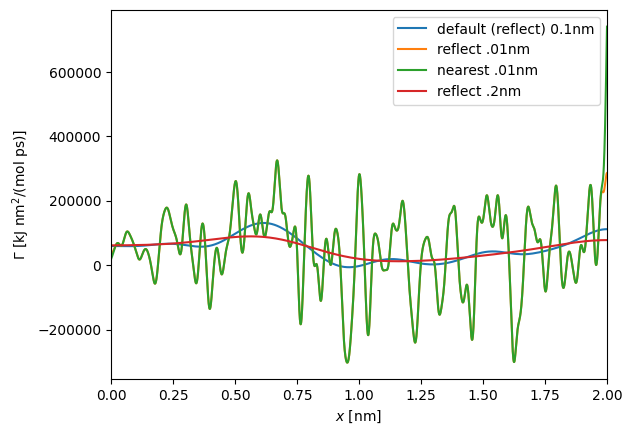

In [12]:
fig, axs = plt.subplots()

x = forceestimator.position_
plotting.plot_Gamma(x,
                    forceestimator.friction_smooth_,
                    axs,
                    label='default (reflect) 0.1nm'
                    )

# using different smoothing windows and modes changes the results significantly
smooth_friction = dcTMD.utils.gaussfilter_friction(forceestimator.friction_,
                                                   x,
                                                   sigma=.01,
                                                   mode='reflect',
                                                   )
axs.plot(x, smooth_friction, label='reflect .01nm')
smooth_friction = dcTMD.utils.gaussfilter_friction(forceestimator.friction_,
                                                   x,
                                                   sigma=.01, 
                                                   mode='nearest',
                                                   )
axs.plot(x, smooth_friction, label='nearest .01nm')
smooth_friction = dcTMD.utils.gaussfilter_friction(forceestimator.friction_,
                                                   x,
                                                   sigma=0.2,
                                                   mode='reflect',
                                                   )
                                                   
axs.plot(x, smooth_friction, label='reflect .2nm')
axs.legend()

plt.show()

### IV. Save and load results


In [15]:
# save forceestimator instance
# dcTMD.storing.save('my_forceestimator', forceestimator)

# save data as .npz and .dat file
outname = 'my_forceestimator_results'
dcTMD.io.write_output(outname, forceestimator)

results = np.load(f'{outname}_N{len(forceestimator.names_)}.npz')

results.files

save file my_forceestimator_results_N18.dat
save file my_forceestimator_results_N18.npz


['x', 'Wmean', 'Wdiss', 'dG', 'Gamma', 'Gamma_smooth']

In [16]:
# load results
results = dcTMD.io.load_output(f'{outname}_N{len(forceestimator.names_)}.npz')
#results = dcTMD.io.load_output(f'{outname}_N{len(workestimator.names_)}.dat')

print(results.keys())

# results is a dictionary-like object
# access e.g. the free energy estimate

results['dG']

Loaded data from my_forceestimator_results_N18.npz
dict_keys(['x', 'Wmean', 'Wdiss', 'dG', 'Gamma', 'Gamma_smooth'])


array([  0.        ,   0.0428709 ,   0.03900755, ..., -10.01580464,
        -9.93160537,  -9.846818  ])